<a href="https://colab.research.google.com/github/vinhqngo5/CS115.Math_For_CS/blob/main/Linear_regression_CS115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Giới thiệu


## 1. Giới thiệu về Linear Regression
Phân tích hồi quy tuyến tính là một phương pháp phân tích quan hệ giữa biến phụ thuộc Y với một hay nhiều biến độc lập X. Mô hình hóa sử dụng hàm tuyến tính (bậc 1). Các tham số của mô hình (hay hàm số) được ước lượng từ dữ liệu.

Hồi quy tuyến tính được sử dụng rộng rãi trong thực tế do tính chất đơn giản hóa của hồi quy. Nó cũng dễ ước lượng.

Trong bài báo cáo này, em sẽ mô phỏng các thuật toán để giải một bài toán Linear Regression thực tế sau đây.

**Bài toán:** Sau một quá trình khảo sát, ta có được điểm thi giữa kì và điểm thi cuối kì môn giải tích của sinh viên UIT. Hãy xây dựng mô hình mà ta có thể dự đoán được điểm thi cuối kì từ điểm thi giữa kì môn giải tích của sinh viên bất kì.

## 2. Mục lục các thuật toán sử dụng
Trong bài báo cáo này, em sẽ sử dụng 2 thuật toán cho bài toán linear regression này:

<ul>
    <li>Sử dụng công thức giả nghịch đảo</li>
    <li>Sử dụng Mini-batch gradient descent</li>
</ul>

# II. Tiến hành các thuật toán





## 1. Khởi tạo dữ liệu

**Nhắc lại bài toán**: Sau một quá trình khảo sát, ta có được điểm thi giữa kì và điểm thi cuối kì môn giải tích của sinh viên UIT. Hãy xây dựng mô hình mà ta có thể dự đoán được điểm thi cuối kì từ điểm thi giữa kì môn giải tích của sinh viên bất kì.


**Khởi tạo dữ liệu:** Ta sẽ tạo bộ dữ liệu với 200 điểm ngẫu nhiên thuộc đường thẳng $y = 0.932x - 1.2$ theo phân phối chuẩn với sigma = 0.1:
> Điểm thi cuối kì = Điểm thi giữa kì * 0.932 - 1.2

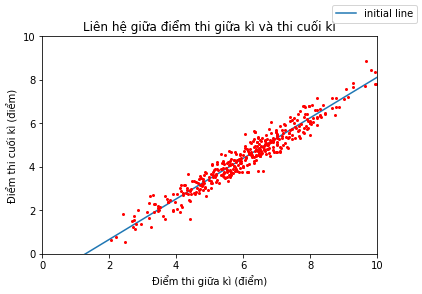

In [ ]:
# Import một số thư viện cần thiết
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
N = 400
w_0, w_1 = -1.2, 0.932

def khoi_tao_du_lieu (N, w_0, w_1, predicted_line=None, saved_path=None):
    # Khởi tạo đường thẳng y = 0.932x - 1.2
    w_0, w_1 = w_0, w_1 # Trọng số của đường thẳng
    N = N # số lượng điểm muốn khởi tạo
    x0 = np.linspace(0, 10, 2) 
    y0 = w_0 + w_1 * x0

    # Khởi tạo N điểm thuộc đường thẳng y = 0.932x - 1.2
    np.random.seed(10)
    X = np.random.normal(6, 1.65, (N, 1))
    Y = w_0 + w_1 * X + np.random.normal(0, 0.4, (N, 1))

    # Vẽ đường thẳng đã khởi tạo
    fig, ax = plt.subplots()
    ax.plot(x0, y0, label='initial line') # Vẽ đường thẳng


    ax.plot(X, Y, 'ro', markersize=2) # Vẽ N điểm dữ liệu
    ax.axis([0, 10, 0, 10])
    ax.set_xlabel('Điểm thi giữa kì (điểm)')
    ax.set_ylabel('Điểm thi cuối kì (điểm)')
    ax.set_title('Liên hệ giữa điểm thi giữa kì và thi cuối kì')

    # Vẽ đường dự đoán (nếu có)
    if (predicted_line is not None):
        predicted_y = predicted_line[0] + predicted_line[1] * x0 
        ax.plot(x0, predicted_y, color='y', label='predicted line')
    fig.legend()

    # save hình lại nếu có 
    if (saved_path is not None):
        fig.savefig(saved_path, dpi=80, bbox_inches='tight')
        fig.clear()
    return X, Y

X, Y = khoi_tao_du_lieu(N, w_0, w_1)

Sau đó, ta tạo dữ liệu bằng cách lấy các điểm theo phân phối chuẩn có kỳ vọng tại 10 điểm có tọa độ như trên, ma trận hiệp phương sai giống nhau và là ma trận đơn vị

## 2. Tìm phương trình hồi quy tuyến tính

**Ý tưởng thuật toán:** ta coi mỗi điểm đầu vào là một vector hàng với dữ liệu đã mở rộng $\textbf{x}=[1 \ x_1 \ x_2 \ ... \ x_d]$. Khi đó ta sẽ có $\hat{y}=f(\textbf{x}) = \textbf{x} * \textbf{w}^T$

**Mục tiêu:** tìm $\textbf{w}$ sao cho sai số dự đoán là nhỏ nhất. Trong đó, sai số dự đoán được tính theo công thức sau:

> $\frac{1}{2}*e=\frac{1}{2}*(y-\hat{y})^2$ 

$\rightarrow$ Hàm mất mát của toàn bộ dữ liệu:  
> $L(w)= \frac{1}{2}*\sum_{i=1}^{n} (y_i-\hat{y}_i)^2 = \frac{1}{2}*\sum_{i=1}^{n} (y_i-{\textbf{x}}_i*\textbf{w}^T)^2$

Để cực tiểu toán hàm Loss trên, trong bài này em sẽ trình bày 2 phương thức và nêu ưu điểm từng loại phương thức

### 2.1. Sử dụng công thức giả nghịch đảo

Như đã nêu trên, hàm Loss của bài toán có dạng:
> $L(w)= \frac{1}{2}*\sum_{i=1}^{n} (y_i-\hat{y}_i)^2 = \frac{1}{2}*\sum_{i=1}^{n} (y_i-{\textbf{x}}_i*\textbf{w}^T)^2$

Đây là một hàm dễ tính đạo hàm, mục tiêu ta là tìm ra bộ tham số $\textbf{w}$ sao cho hàm trên đạt cực tiểu $\rightarrow$ đạo hàm theo $\textbf{w}$

Sau khi giải phương trình đạo hàm = 0, ta có được điểm tối ưu của bài toán Linear regression có dạng: 
> $\textbf{w}=({\textbf{X}}^T*{\textbf{X}})^{+}*{\textbf{X}}^T*\textbf{y}$
>> - ${\textbf{X}}=[{\textbf{x}}_1 \ {\textbf{x}}_2 ... \ {\textbf{x}}_n]$ là ma trận các vector dữ liệu đầu vào mở rộng của training data
>> - $\textbf{y}$ là vector các dữ liệu output của training data


Mô hình ban đầu: y = -1.2 + 0.932 * x
Mô hình dự đoán: y = -1.110 + 0.915 * x


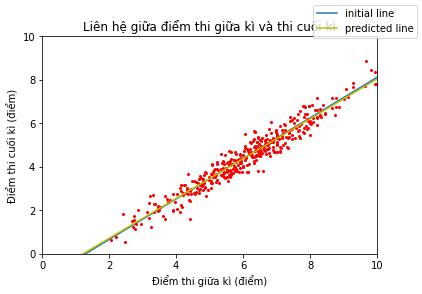

In [ ]:
# Chuyển dữ liệu đầu vào thành ma trận cột
reshaped_X = X.reshape(N, 1)
reshaped_Y = Y.reshape(N, 1)

# chuyển ma trận X thành ma trận X mở rộng
reshaped_X = np.concatenate((np.ones((N, 1)), reshaped_X), axis=1) 

# Tính toán các trọng số của phương trình hồi quy
A = np.dot(reshaped_X.T, reshaped_X)
b = np.dot(reshaped_X.T, reshaped_Y)
w = np.dot(np.linalg.pinv(A), b)

khoi_tao_du_lieu(N, w_0, w_1, w)

print('Mô hình ban đầu: y = {} + {} * x'.format(w_0, w_1))
print('Mô hình dự đoán: y = {:.3f} + {:.3f} * x'.format(float(w[0]), float(w[1])))

Như đã thấy trên, sử dụng công thức giả nghịch đảo ra kết quả tương đối chính xác với tốc độ nhanh. Tuy nhiên với điều kiện tiên quyết là phải giải được phương trình đạo hàm = 0. Trong thực tế, không nhiều hàm có thể giải được PT đạo hàm = 0 $\rightarrow$ Thuật toán gradient descent

### 2.2. Sử dụng thuật toán Mini-batch Gradient Descent

Trong Machine Learning nói riêng và Toán Tối Ưu nói chung, chúng ta thường xuyên phải tìm giá trị nhỏ nhất (hoặc đôi khi là lớn nhất) của một hàm số nào đó. Nhìn chung, việc tìm global minimum của các hàm mất mát trong Machine Learning là rất phức tạp, thậm chí là bất khả thi.

$\rightarrow$ Hướng tiếp cận phổ biến nhất là xuất phát từ một điểm mà chúng ta coi là gần với nghiệm của bài toán, sau đó dùng một phép toán lặp để tiến dần đến điểm cần tìm, tức đến khi đạo hàm gần với 0. Gradient Descent (viết gọn là GD) và các biến thể của nó là một trong những phương pháp được dùng nhiều nhất.

Mini-batch gradient descent là một thuật toán biến thể của gradient descent với số lần cập nhật nhiều hơn mỗi epoch $\rightarrow$ hội tụ nhanh hơn

Công thức cập nhật của mini-batch gradient descent:
> $\theta = \theta - \eta\nabla_{\theta}J(\theta; \textbf{x}_{i:i+n}; \textbf{y}_{i:i+n})$

>> - n: là số lượng điểm dữ liệu ứng với mini batch
>> - $\textbf{x}_{i:i+n}$ được hiểu là dữ liệu từ thứ $i$ tới thứ $i + n - 1$

In [ ]:
!mkdir  "/content/visualize"
# Chuyển dữ liệu đầu vào thành ma trận cột
reshaped_X = X.reshape(N, 1)
reshaped_Y = Y.reshape(N, 1)
reshaped_X = np.concatenate((np.ones((N, 1)), reshaped_X), axis=1) 

# Tính hàm cost đối với training dataset
def cost(X0, Y0, weight):
    N = X0.shape[0]
    return np.sum(np.square(np.dot(X0, weight.T).reshape(N, 1) - Y0) / (2 * N))

# Tính đạo hàm dựa trên công thức f'(x) = (f(x + eps) - f(x - eps)) / (2 * eps)
def sgrad(weight, start, end, rd_id, Xbar, Ybar):
    eps = 1e-6
    g = np.zeros_like(weight)
    indices = rd_id[start : end]
    X0 = np.take(Xbar.T[0], indices)
    X1 = np.take(Xbar.T[1], indices)
    X0, X1 = np.asmatrix(X0), np.asmatrix(X1)
    Xbar = np.concatenate((X0, X1), axis=0).T
    Ybar = np.take(Ybar.T, indices).reshape(end - start, 1)
    for i in range(len(weight)):
        w_p = weight.copy()
        w_n = weight.copy()
        w_p[i] += eps 
        w_n[i] -= eps
        g[i] = (cost(Xbar, Ybar, w_p) - cost(Xbar, Ybar, w_n)) / (2 * eps)
    return g 

# Tính minibatch GD của hàm
def SGD(w_init, eta, n, reshaped_X, reshaped_Y):
    gif, count = 0, 0
    all_w = [w_init]
    w_last_check = w_init
    iter_check_w = 10
    N = reshaped_X.shape[0]
    for epoch in range(200):
        # Xuất đồ thị ra ảnh để tạo gif
        if (epoch % 5 == 0):
            khoi_tao_du_lieu(N, w_0, w_1, all_w[-1], '/content/visualize/{}.png'.format(gif))
            gif += 1
        # shuffle data 
        rd_id = np.random.permutation(N)
        for i in range(0, N, n):
            count += 1 
            g = sgrad(all_w[-1], i, min(N, n + i), rd_id, reshaped_X, reshaped_Y)
            w_new = all_w[-1] - eta * g
            all_w.append(w_new)
            loss = cost(reshaped_X, reshaped_Y, w_new)
            print('iter : {}   loss: {}'.format(count, loss))
            if count % iter_check_w == 0:
                w_this_check = w_new
                if np.linalg.norm(w_this_check - w_last_check) / len(w_init) < 1e-6: 
                    print ('break')                                   
                    return all_w[-1]
                w_last_check = w_this_check
    return all_w[-1]
w = SGD(np.array([float(5), float(-1)]), 0.03, 10, reshaped_X, reshaped_Y)
print(w)

In [ ]:
# Xuất ra kết quả của mini-batch gradient descent
print(w)

[-1.12936754  0.95032291]


In [ ]:
# Chuyển các plot được lưu trong thư mục visualize thành gif

import imageio
import os
def gif_init(folder_path):
    folder_path = folder_path
    all_file = os.listdir(folder_path)
    file_paths = []
    for i in range(len(all_file)):
        file_path = os.path.join(folder_path, '{}.png'.format(i))
        file_paths.append(file_path)

    images = []
    for file_path in file_paths:
        images.append(imageio.imread(file_path))
        
    gif_name = os.path.basename(folder_path)
    imageio.mimsave('/content/{}.gif'.format(gif_name), images, duration=0.25)

gif_init('/content/visualize')
!rm -rf "/content/visualize"


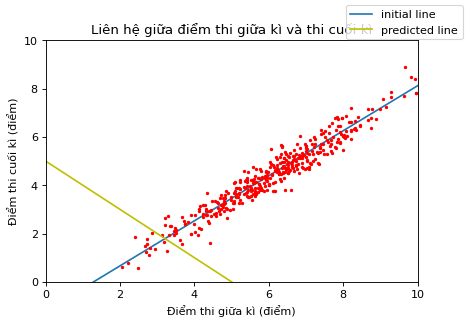

In [ ]:
# Hàm hiển thị ảnh gif
from IPython.display import Image
def gif(gif_path):
    with open(gif_path,'rb') as file:
        display(Image(file.read()))
# show gif
gif('/content/visualize.gif')